In [1]:
import re
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt

import pickle as pkl

from sklearn.model_selection import train_test_split

import keras.metrics
from keras import regularizers, initializers, optimizers, callbacks
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.layers import *
from keras.models import Model

Using TensorFlow backend.


In [2]:
spacy_nlp = spacy.load('en_core_web_sm')

In [3]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [4]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "glove_data/glove.6B/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [5]:
mbti_df_clean = pd.read_pickle("data/output_pickles/mbti_clean_text.pkl")
result_umap_types  = pd.read_csv("data/output_csv/result_umap_types.csv")

In [6]:
mbti_df_clean.head()

,type,posts,type_clean,posts_clean,type_lemma,posts_lemma
0,infj,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,infj,intj moments sportscenter plays pranks life ch...,infj,intj moment sportscent play prank life change ...
1,entp,'I'm finding the lack of me in these posts ver...,entp,finding lack posts alarming sex boring positio...,entp,find lack post alarming sex bore position exam...
2,intp,'Good one _____ https://www.youtube.com/wat...,intp,good course know blessing curse absolutely pos...,intp,good course know blessing curse absolutely pos...
3,intj,"'Dear INTP, I enjoyed our conversation the o...",intj,dear intp enjoyed conversation day esoteric ga...,intj,dear intp enjoy conversation day esoteric gabb...
4,entj,'You're fired.|||That's another silly misconce...,entj,fired silly misconception approaching logicall...,entj,fire silly misconception approach logically go...


In [7]:
result_umap_types.head()

,Unnamed: 0,type,words_per_comment,variance_of_word_counts,enfj,enfp,entj,entp,esfj,esfp,...,infj,infp,intj,intp,isfj,isfp,istj,istp,0,1
0,0,infj,11.12,135.2900,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,3.910143,7.477874
1,1,entp,23.40,187.4756,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,3.938040,5.939636
2,2,intp,16.72,180.6900,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,3.740153,5.486389
3,3,intj,21.28,181.8324,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,5.415134,7.452929
4,4,entj,19.34,196.4576,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,2.083198,7.512875


In [8]:
labels = ["enfj", "enfp", "entj", "entp", "esfj", "esfp", "estj", "estp", "infj", "infp", "intj", "intp", "isfj", 
          "isfp", "istj", "istp"]
y = result_umap_types[labels].values
X = mbti_df_clean["posts_clean"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(6940,) (6940, 16) (1735,) (1735, 16)


In [10]:
X_train = list(X_train)

In [11]:
texts = [line for line in X_train] 

In [12]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

In [13]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 90265


In [14]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y_train.shape)

Shape of data tensor: (6940, 200)
Shape of label tensor: (6940, 16)


In [15]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y_train[indices]

In [16]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

print ((x_train.shape),(y_train.shape),(x_val.shape),(y_val.shape))

(5552, 200) (5552, 16) (1388, 200) (1388, 16)


In [17]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [ 124  443  154  444   29   34   22   57  944 1177  732  805   90  160
  126  211]
validation:  [ 25 107  33 106   6   6  10  17 238 285 166 206  31  58  35  59]


In [18]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [    5   498    24   131     1  1323   114  1598   537 10077  1209   336
   841 10473   286   184   631   612  3902   102  1863   127 14364   589
  1040  3611     7  4256    44     2   177  4385 36274  1136     7   252
  1123  1470    67     3   230   770  8411   230  2901    35     3    48
  6726    38    10   949  1542   831   376   148  1322     1  7469 26261
  6189     7  6189    14     2   190   190  1167   279   105  1202    10
   434   711   709   443  8996   530  1455    16  1235  5146    47    82
    70  3440   971  2782  3972   183  4669  1582   272 18570  5405  5283
   271  5944 10227  1018     9   696    19   458    19   479   468   718
  2650   322 15702  2824  5146  9507    37   489   173 45645 29341  1076
  4274   328    79    30   813  1235   220    21 83757  2952   741    80
   267 83758   360   307   344 21689   336   320   698    10     5   133
  1984  4181    47  1842    63 28835 14459    60    36  9006 83759  1579
  3166     1  1664 15594    

In [19]:
embeddings_index = {}
f = open(GLOVE_DIR, encoding="UTF-8")
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: glove_data/glove.6B/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [20]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

In [21]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(16, activation="softmax")(x)

In [22]:
model = Model(sequence_input, preds)
model.compile(loss = 'categorical_crossentropy',
             optimizer='adam',
             metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 100)          9026600   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           38640     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0   

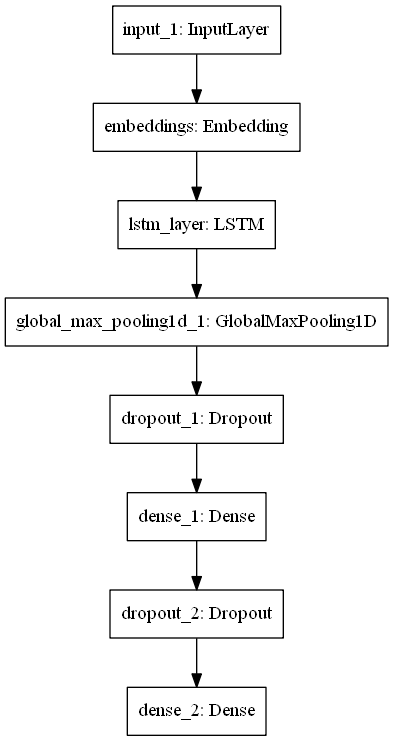

In [23]:
from keras.utils import plot_model
plot_model(model)

In [24]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 20, batch_size=4, validation_data=(x_val, y_val))

Training progress:
Train on 5552 samples, validate on 1388 samples
Epoch 1/20
5552/5552 [==============================] - 83s 15ms/step - loss: 2.2543 - accuracy: 0.2444 - precision_1: 0.5217 - recall_1: 0.0043 - auc_1: 0.7952 - val_loss: 2.1709 - val_accuracy: 0.2918 - val_precision_1: 0.5000 - val_recall_1: 7.2046e-04 - val_auc_1: 0.8142
Epoch 2/20
5552/5552 [==============================] - 82s 15ms/step - loss: 2.0687 - accuracy: 0.3383 - precision_1: 0.6256 - recall_1: 0.0439 - auc_1: 0.8321 - val_loss: 1.9966 - val_accuracy: 0.3804 - val_precision_1: 0.6977 - val_recall_1: 0.1081 - val_auc_1: 0.8401
Epoch 3/20
5552/5552 [==============================] - 81s 15ms/step - loss: 1.8561 - accuracy: 0.4283 - precision_1: 0.6795 - recall_1: 0.1780 - auc_1: 0.8640 - val_loss: 1.8456 - val_accuracy: 0.4280 - val_precision_1: 0.6725 - val_recall_1: 0.2205 - val_auc_1: 0.8622recall_1: 0.1718 - auc_1 - ETA: 7s - loss: 1.8717 - accuracy: 0 - ETA: 3s - loss: 1.8638 - accuracy: 0.4261 - 
Epo

In [ ]:
print(history.history)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [ ]:
precision = history.history['precision_1']
val_precision = history.history['val_precision_1']

plt.plot(epochs, precision, label='Training precision')
plt.plot(epochs, val_accuracy, label='Validation precision')
plt.title('Training and validation precision')
plt.ylabel('Precision')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [ ]:
recall = history.history['recall_1']
val_recall = history.history['val_recall_1']

plt.plot(epochs, recall, label='Training recall')
plt.plot(epochs, val_recall, label='Validation recall')
plt.title('Training and validation recall')
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [ ]:
auc = history.history['auc_1']
val_auc = history.history['val_auc_1']

plt.plot(epochs, auc, label='Training auc')
plt.plot(epochs, val_auc, label='Validation auc')
plt.title('Training and validation auc')
plt.ylabel('AUC')
plt.xlabel('Epochs')
plt.legend()
plt.show();

another trial with f1 score

In [29]:
f1_m = 2*((precision*recall)/(precision+recall+epsilon))

TypeError: unsupported operand type(s) for *: 'Precision' and 'Recall'